In [5]:
# notebook imports

import math
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import matplotlib.image as mpimg
import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img

In [6]:
# make model call backs

save_path = 'model_experiments'

def create_model_checkpoint(model_name, save_path=save_path):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0, 
                                              save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=50,
                                                  restore_best_weights=True)

reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                      patience=500,
                                                      verbose=1)

In [7]:
# helper functions
from helper_functions import plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [8]:
# get data

# face_data2 = '/content/drive/MyDrive/Colab Notebooks/Face_expression_recognition_project/face_expression/face_expression.zip'
# unzip_data(face_data2)


train_dir = 'data/train'
validation_dir = 'data/validation'

In [9]:
import os
from PIL import Image
folder_path = 'data/validation/'
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

In [10]:
# How many images/classes are there?
walk_through_dir("data")

There are 2 directories and 0 images in 'data'.
There are 3 directories and 0 images in 'data\train'.
There are 0 directories and 37 images in 'data\train\anthracnose'.
There are 0 directories and 39 images in 'data\train\cercospora_leaf_spot'.
There are 0 directories and 42 images in 'data\train\phosphorus_deficiency'.
There are 3 directories and 0 images in 'data\validation'.
There are 0 directories and 15 images in 'data\validation\anthracnose'.
There are 0 directories and 10 images in 'data\validation\cercospora_leaf_spot'.
There are 0 directories and 11 images in 'data\validation\phosphorus_deficiency'.


In [11]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)

data_dir = pathlib.Path("data/train/") 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['anthracnose' 'cercospora_leaf_spot' 'phosphorus_deficiency']


In [12]:
# set target and batch size of image
TARGET_SIZE = (224, 224)
BATCH_SIZE = 128

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE, 
                                               target_size=TARGET_SIZE,
                                               class_mode="categorical", 
                                               seed=42)

valid_data = validation_datagen.flow_from_directory(validation_dir,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=TARGET_SIZE,
                                                    class_mode="categorical",
                                                    seed=42)

Found 118 images belonging to 3 classes.
Found 36 images belonging to 3 classes.


# Model 0

In [13]:
# creat model: Base model

num_classes = len(class_names)

# Create a CNN model
model_0 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, 
                           kernel_size=3, 
                           activation="relu",
                           input_shape=(224, 224, 7)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), 
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation="softmax")
], name='model_0')

# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [14]:
model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                       

In [15]:
model_0.name

'model_0'

In [16]:
%%time
# Fit the model
callbacks_list = [create_model_checkpoint(model_0.name), early_stopping, reduce_plateau]

history_0 = model_0.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=callbacks_list)

Epoch 1/10
1/1 [==============================] - 125s 125s/step - loss: 1.1025 - accuracy: 0.2797 - val_loss: 1.1338 - val_accuracy: 0.3056 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - 100s 100s/step - loss: 1.0713 - accuracy: 0.3559 - val_loss: 1.0706 - val_accuracy: 0.3056 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - 91s 91s/step - loss: 1.0377 - accuracy: 0.3559 - val_loss: 1.0705 - val_accuracy: 0.3056 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - 87s 87s/step - loss: 0.9801 - accuracy: 0.5593 - val_loss: 1.0786 - val_accuracy: 0.2778 - lr: 0.0010
Epoch 5/10
1/1 [==============================] - 93s 93s/step - loss: 0.9458 - accuracy: 0.5000 - val_loss: 0.9884 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 6/10
1/1 [==============================] - 92s 92s/step - loss: 0.8975 - accuracy: 0.7034 - val_loss: 0.9745 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 7/10
1/1 [==============================] - 86s 86s/step - loss: 0.8202 - accu

In [17]:
model_0.evaluate(valid_data)

1/1 [==============================] - 19s 19s/step - loss: 0.9681 - accuracy: 0.5556


[0.9681273698806763, 0.5555555820465088]

In [18]:
saved_model = tf.keras.models.load_model('model_experiments/model_0/')
saved_model.evaluate(valid_data)

1/1 [==============================] - 20s 20s/step - loss: 0.8953 - accuracy: 0.6667


[0.8952634334564209, 0.6666666865348816]

In [33]:
c = ['abacha', 'boli', 'jellof_rice', 'suya']
cuisines = {
    'abacha': 'Abacha is a nigerian food',
    'boli': 'Boli, also know as roasted plantain',
    'jellof_rice': 'Jellof_rice is a delicious Nigerian meal',
    'suya': 'Suya is a grilled beef sold usually at night'
}

In [19]:
# make Prediction

# Create a function to import an image and resize it to be able to be used with our model
def plot_and_pred(model, filename, img_shape=224):
    img = tf.io.read_file(filename)

    img = tf.image.decode_image(img, channels=3)

    img = tf.image.resize(img, size = [img_shape, img_shape])

    img = img/255.
    
    img = tf.expand_dims(img, axis=0)
    pred = model.predict(img)
    prob = f'{math.ceil(pred.max()*100)}%'
    pred_class = class_names[int(np.argmax(pred))]
    
    plt.title(f'{pred_class.title()} {prob}')
#     plt.xlabel(cuisines[pred_class])
    plt.grid(False)
    plt.axis(False)
    plt.imshow(np.squeeze(img))
    
    return pred_class

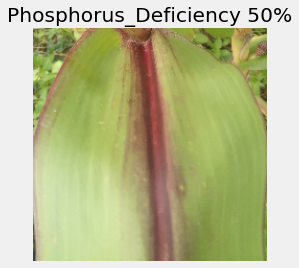

In [32]:
# plt.figure(figsize=(5, 5))
p = plot_and_pred(saved_model, 'test3.jpg')

<AxesSubplot:>

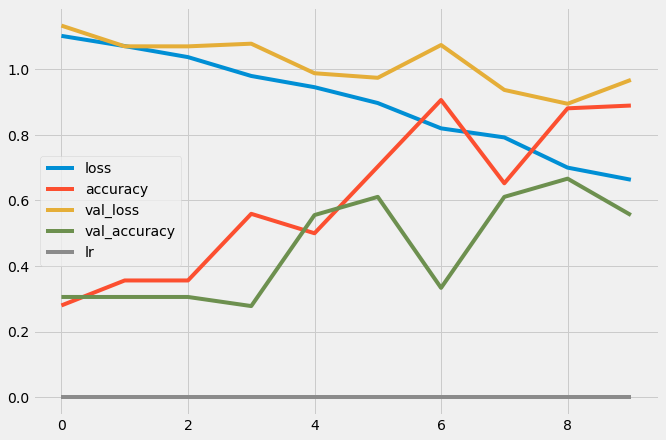

In [33]:
pd.DataFrame(history_0.history).plot(figsize=(10, 7))

In [129]:
def load_and_prep_image(filename, img_shape=224):
    img = tf.io.read_file(filename)

    img = tf.image.decode_image(img, channels=3)

    img = tf.image.resize(img, size = [img_shape, img_shape])

    img = img/255.
    
    img = tf.expand_dims(img, axis=0)
    
    return img

sample_image = load_and_prep_image("61.jpg")
pred = model_0.predict(sample_image)
prob = math.ceil(pred.max()*100)
pred_class = class_names[int(np.argmax(pred))]
print(f'Prediction: {pred_class} \nConf: {prob}%')

Prediction: jellof_rice 
Conf: 100%


# Model 1
## same model as model 0, but with data augmentation

In [132]:
# set target and batch size of image
TARGET_SIZE = (224, 224)
BATCH_SIZE = 128

# Set the seed
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=.2,
                                   zoom_range=.2,
                                   width_shift_range=.1,
                                   height_shift_range=.1,
                                   rotation_range=20,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale= 1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE, 
                                               target_size=TARGET_SIZE,
                                               class_mode="categorical", 
                                               seed=42)

valid_data = validation_datagen.flow_from_directory(validation_dir,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=TARGET_SIZE,
                                                    class_mode="categorical",
                                                    seed=42)

Found 784 images belonging to 4 classes.
Found 192 images belonging to 4 classes.


In [133]:
# create model: model 1

num_classes = len(class_names)

# Create a CNN model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, 
                           kernel_size=3, 
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), 
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation="softmax")
], name='model_1')

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [134]:
%%time
# Fit the model
callbacks_list = [create_model_checkpoint(model_1.name), early_stopping, reduce_plateau]

history_1 = model_1.fit(train_data,
                        epochs=10,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=callbacks_list)

Epoch 1/10
7/7 [==============================] - 173s 25s/step - loss: 1.3833 - accuracy: 0.2628 - val_loss: 1.3320 - val_accuracy: 0.4010 - lr: 0.0010
Epoch 2/10
7/7 [==============================] - 157s 22s/step - loss: 1.2994 - accuracy: 0.3763 - val_loss: 1.2208 - val_accuracy: 0.4271 - lr: 0.0010
Epoch 3/10
7/7 [==============================] - 154s 25s/step - loss: 1.1667 - accuracy: 0.4452 - val_loss: 1.1140 - val_accuracy: 0.5104 - lr: 0.0010
Epoch 4/10
7/7 [==============================] - 117s 15s/step - loss: 1.0849 - accuracy: 0.4860 - val_loss: 1.0517 - val_accuracy: 0.5677 - lr: 0.0010
Epoch 5/10
7/7 [==============================] - 51s 7s/step - loss: 1.0399 - accuracy: 0.5179 - val_loss: 1.0207 - val_accuracy: 0.5104 - lr: 0.0010
Epoch 6/10
7/7 [==============================] - 54s 8s/step - loss: 0.9623 - accuracy: 0.5612 - val_loss: 1.0013 - val_accuracy: 0.5521 - lr: 0.0010
Epoch 7/10
7/7 [==============================] - 52s 7s/step - loss: 0.9163 - accurac

In [137]:
model_1.evaluate(valid_data)

2/2 [==============================] - 6s 1s/step - loss: 0.9006 - accuracy: 0.5938


[0.9006102681159973, 0.59375]

In [138]:
saved_model = tf.keras.models.load_model('model_experiments/model_1/')
saved_model.evaluate(valid_data)

2/2 [==============================] - 6s 1s/step - loss: 0.8315 - accuracy: 0.6615


[0.8314712643623352, 0.6614583134651184]

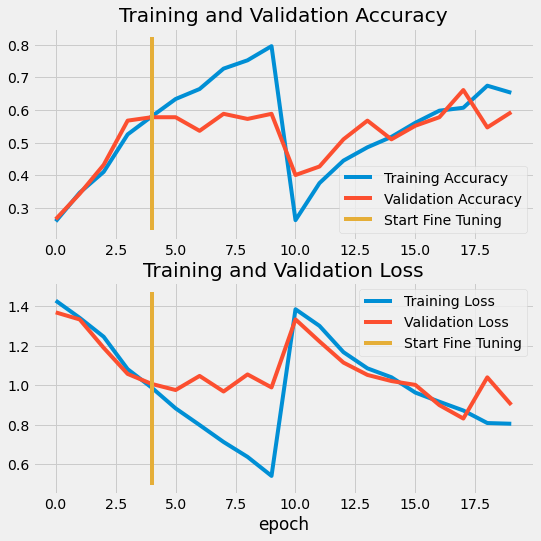

In [207]:
compare_historys(history_0, history_1)

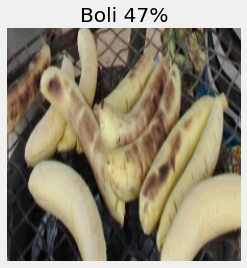

In [186]:
p = plot_and_pred(model_1, r"C:\Users\Ben\DS_and_ML\data\food\0000 (76).jpg")

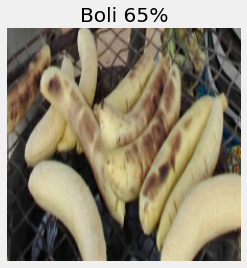

In [187]:
p = plot_and_pred(saved_model, r"C:\Users\Ben\DS_and_ML\data\food\0000 (76).jpg")

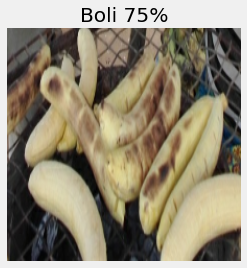

In [188]:
p = plot_and_pred(model_0, r"C:\Users\Ben\DS_and_ML\data\food\0000 (76).jpg")

# Model 2
## same model as model 1, but with full dataset

In [6]:
# set target and batch size of image
TARGET_SIZE = (224, 224)
BATCH_SIZE = 128

# Set the seed
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=.2,
                                   zoom_range=.2,
                                   width_shift_range=.1,
                                   height_shift_range=.1,
                                   rotation_range=20,
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale= 1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE, 
                                               target_size=TARGET_SIZE,
                                               class_mode="categorical", 
                                               seed=42)

valid_data = validation_datagen.flow_from_directory(validation_dir,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=TARGET_SIZE,
                                                    class_mode="categorical",
                                                    seed=42)

Found 2475 images belonging to 18 classes.
Found 616 images belonging to 18 classes.


In [7]:
# create model: model 2

num_classes = len(class_names)

# Create a CNN model
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, 
                           kernel_size=3, 
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), 
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation="softmax")
], name='model_2')

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [8]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                       

In [10]:
%%time
# Fit the model
callbacks_list = [create_model_checkpoint(model_2.name), early_stopping, reduce_plateau]

history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        callbacks=callbacks_list)

Epoch 1/5
20/20 [==============================] - 320s 16s/step - loss: 2.7585 - accuracy: 0.1236 - val_loss: 2.6092 - val_accuracy: 0.1899 - lr: 0.0010
Epoch 2/5
20/20 [==============================] - 166s 8s/step - loss: 2.4347 - accuracy: 0.2242 - val_loss: 2.4717 - val_accuracy: 0.2305 - lr: 0.0010
Epoch 3/5
20/20 [==============================] - 243s 12s/step - loss: 2.2837 - accuracy: 0.2586 - val_loss: 2.3036 - val_accuracy: 0.2565 - lr: 0.0010
Epoch 4/5
20/20 [==============================] - 466s 23s/step - loss: 2.1904 - accuracy: 0.2994 - val_loss: 2.3782 - val_accuracy: 0.2532 - lr: 0.0010
Epoch 5/5
20/20 [==============================] - 468s 23s/step - loss: 2.1052 - accuracy: 0.3212 - val_loss: 2.1997 - val_accuracy: 0.3360 - lr: 0.0010
Wall time: 28min 34s


<AxesSubplot:>

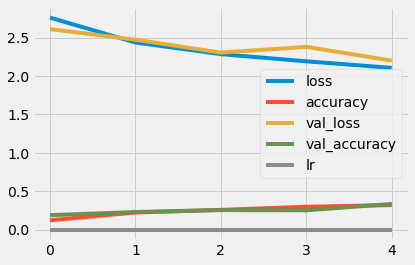

In [15]:
pd.DataFrame(history_2.history).plot()

In [16]:
model_2.evaluate(valid_data)

5/5 [==============================] - 78s 15s/step - loss: 2.1997 - accuracy: 0.3360


[2.1997134685516357, 0.3360389471054077]

In [17]:
saved_model = tf.keras.models.load_model('model_experiments/model_2/')
saved_model.evaluate(valid_data)

5/5 [==============================] - 64s 12s/step - loss: 2.1997 - accuracy: 0.3360


[2.199713706970215, 0.3360389471054077]

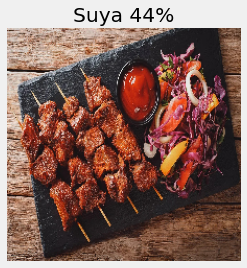

In [37]:
p = plot_and_pred(model_2, '58.jpg')
cuisines[p]

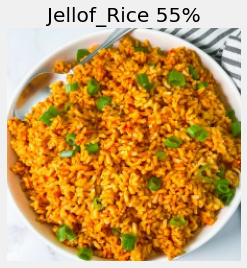

In [46]:
p = plot_and_pred(model_2, '25.jpg')
# cuisines[p]

In [59]:
class_names = ['abacha', 'akara', 'jellof_rice', 'moin_moin', 'pounded_yam', 'suya']

def plot_and_pred(model, filename, img_shape=224):
    img = tf.io.read_file(filename)

    img = tf.image.decode_image(img, channels=3)

    img = tf.image.resize(img, size = [img_shape, img_shape])

    img = img/255.
    
    img = tf.expand_dims(img, axis=0)
    pred = model.predict(img)
    prob = f'{math.ceil(pred.max()*100)}%'
    pred_class = class_names[int(np.argmax(pred))]
    
    plt.title(f'{pred_class.title()} {prob}')
#     plt.xlabel(cuisines[pred_class])
    plt.grid(False)
    plt.axis(False)
    plt.imshow(np.squeeze(img))
    
    return pred_class

In [66]:
model = tf.keras.models.load_model('saved_models/model_0.h5')
model_0_saved = tf.keras.models.load_model('saved_models/model_0_saved.h5')

In [176]:
test_image = 'test/1.jpeg'

'abacha'

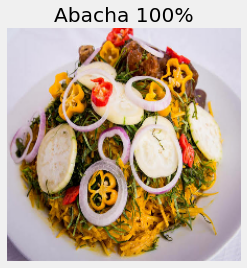

In [177]:
plot_and_pred(model, test_image)

'abacha'

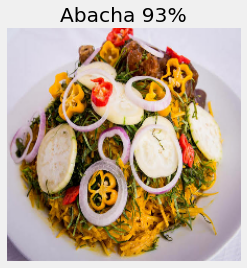

In [178]:
plot_and_pred(model_0_saved, test_image)